In [ ]:
"""
Part1: 
This code reads an Excel file containing MR imaging data, 
groups the data by the 'Group' column, 
and calculates the mean and variance for several imaging parameters, 
including scan duration, time, TE, TR, 
bandwidth, slice thickness, and the number of slices. 
The resulting statistics are printed and saved to a new Excel file."
"""
import pandas as pd

# Read the Excel file (replace 'your_excel_file.xlsx' with your actual file name)
df = pd.read_excel('/Users/ziling/Desktop/MRCP/data_excel/temp.xlsx')

# Group by 'Group' and calculate the mean and variance for the relevant columns
stats = df.groupby('Group').agg(
    scandurati_mean=('scanduration', 'mean'),
    scandurati_var=('scanduration', 'var'),
    time_mean=('time', 'mean'),
    time_var=('time', 'var'),
    TE_mean=('TE', 'mean'),
    TE_var=('TE', 'var'),
    TR_mean=('TR', 'mean'),
    TR_var=('TR', 'var'),
    Bandwidth_mean=('Bandwidth', 'mean'),
    Bandwidth_var=('Bandwidth', 'var'),
    slice_thickness_mean=('slice_thickness', 'mean'),
    slice_thickness_var=('slice_thickness', 'var'),
    num_slices_mean=('num_slices', 'mean'),
    num_slices_var=('num_slices', 'var')
)

# Output the result
print(stats)

# If you want to save the result to an Excel file
stats.to_excel('/Users/ziling/Desktop/MRCP/data_excel/grouped_stats_output.xlsx')

In [ ]:
"""
Part2:
This script processes MRCP data by calculating the median and interquartile range (IQR)
for metrics such as SNR, Contrast, CNR, and FWHM, grouped by 'Group' and 'Radius'.
The results are saved as separate CSV files for each unique 'Radius' value, allowing
for subsequent analysis and comparison across groups.
"""
import pandas as pd
# Define a function to load the Excel file, calculate the median and IQR range, and save the results
def process_data(file_path, output_dir):
    # Load the Excel file
    df = pd.read_excel(file_path)    
    # Define a function to calculate IQR range as a string
    def iqr_range(x):
        q1 = x.quantile(0.25)
        q3 = x.quantile(0.75)
        return f"{q1:.2f} - {q3:.2f}"  # Formatting the range as a string
    # Group by both 'Group' and 'Radius' and calculate the median and IQR range for each metric
    grouped_stats = df.groupby(['Group', 'Radius']).agg(
        SNR_median=('SNR', 'median'),
        SNR_IQR=('SNR', iqr_range),
        Contrast_median=('Contrast', 'median'),
        Contrast_IQR=('Contrast', iqr_range),
        CNR_median=('CNR', 'median'),
        CNR_IQR=('CNR', iqr_range),
        FWHM_median=('FWHM', 'median'),
        FWHM_IQR=('FWHM', iqr_range)
    ).reset_index()
    # Extract unique Radius values
    unique_radii = df['Radius'].unique()

    # Save results for each Radius group
    for radius in unique_radii:
        # Filter for the specific radius
        radius_stats = grouped_stats[grouped_stats['Radius'] == radius]
        
        # Construct the output file path based on the radius
        output_path = f"{output_dir}/MRCP_LocData_stats_{radius}.csv"
        
        # Save the results to a CSV file
        radius_stats.to_csv(output_path, index=False)
        
        # Display the results
        print(f"Results for Radius {radius}:")
        print(radius_stats)
        print("\n")

# File paths for 6-voxel and 12-voxel data
file_paths = [
    ('/Users/ziling/Desktop/MRCP/results/MRCP_LocData.xlsx', 
     '/Users/ziling/Desktop/MRCP/results/')
]
# Process both files
for file_path, output_dir in file_paths:
    process_data(file_path, output_dir)

In [ ]:
"""
Part3:to test for normality using the Shapiro-Wilk test
"""

import pandas as pd
from scipy.stats import shapiro
import numpy as np

def check_normality(df, columns, group, radius, transform=None):
    normality_results = []
    
    for column in columns:
        # Apply log transformation if specified, avoiding log(0)
        data = np.log(df[column].replace(0, np.nan)).dropna() if transform == 'log' else df[column].dropna()
        
        # Perform the Shapiro-Wilk test
        stat, p_value = shapiro(data)
        normality_results.append({
            'Group': group,
            'Radius': radius,
            'Metric': column,
            'Transform': transform if transform else 'None',
            'Statistic': stat,
            'p-value': p_value,
            'Distribution': 'Normally distributed' if p_value > 0.05 else 'Not normally distributed'
        })
        
        # Print the results
        print(f"{column} ({'log-transformed' if transform == 'log' else 'original'}) for Group: {group}, Radius: {radius}: "
              f"Data is {'normally distributed' if p_value > 0.05 else 'NOT normally distributed'} (p = {p_value:.3f})")
    
    return normality_results

# Define a reusable function to load data, perform normality tests by Group and Radius, and display results
def process_normality_tests(file_path, columns_to_check):
    # Load the Excel file
    df = pd.read_excel(file_path)
    
    # Ensure 'Group' and 'Radius' columns are present
    if 'Group' not in df.columns or 'Radius' not in df.columns:
        raise KeyError("The dataset must contain 'Group' and 'Radius' columns.")
    
    all_results = []
    
    # Group the data by 'Group' and 'Radius' and perform the tests
    grouped_df = df.groupby(['Group', 'Radius'])
    
    for (group, radius), group_data in grouped_df:
        print(f"\nNormality test for Group: {group}, Radius: {radius} (Original Data):")
        original_results = check_normality(group_data, columns_to_check, group, radius)
        
        print(f"\nNormality test for Group: {group}, Radius: {radius} (Log-transformed Data):")
        log_results = check_normality(group_data, columns_to_check, group, radius, transform='log')
        
        # Combine results from original and log-transformed data
        all_results.extend(original_results)
        all_results.extend(log_results)
    
    # Convert the results into a DataFrame for better readability
    normality_combined_df = pd.DataFrame(all_results)
    
    # Display the combined results
    print("\nCombined normality test results:")
    print(normality_combined_df)
    
    return normality_combined_df

# List of columns to check for normality
columns_to_check = ["SNR", "Contrast", "CNR", "FWHM"]
# File paths for 6-voxel and 12-voxel data
file_paths = [
    '/Users/ziling/Desktop/MRCP/results/MRCP_LocData.xlsx'
]

# Process both files and perform normality tests by Group and Radius
for file_path in file_paths:
    print(f"\nProcessing file: {file_path}")
    process_normality_tests(file_path, columns_to_check)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Using zero_method  wilcox
RTr0 v.s. RTr1: Wilcoxon test (paired samples) with Bonferroni correction, P_val=3.134e-05 stat=1.679e+04
Using zero_method  wilcox
RTr1 v.s. BH0: Wilcoxon test (paired samples) with Bonferroni correction, P_val=7.831e-26 stat=7.239e+03
Using zero_method  wilcox
BH0 v.s. BH1: Wilcoxon test (paired samples) with Bonferroni correction, P_val=1.000e+00 stat=2.330e+04
Using zero_method  wilcox
RTr0 v.s. BH0: Wilcoxon test (paired samples) with Bonferroni correction, P_val=5.523e-20 stat=9.343e+03
Using zero_method  wilcox
RTr1 v.s. BH1: Wilcoxon test (paired samples) with Bonferroni correction, P_val=2.300e-29 stat=6.085e+03
Using zero_method  wilcox
RTr0 v.s. BH1: Wilcoxon test (paired samples) with Bonferroni correction, P_val=1.015e-19 stat=9.445e+03
p-value annotation legend:
ns: 5.00e-02 < p <= 1.0

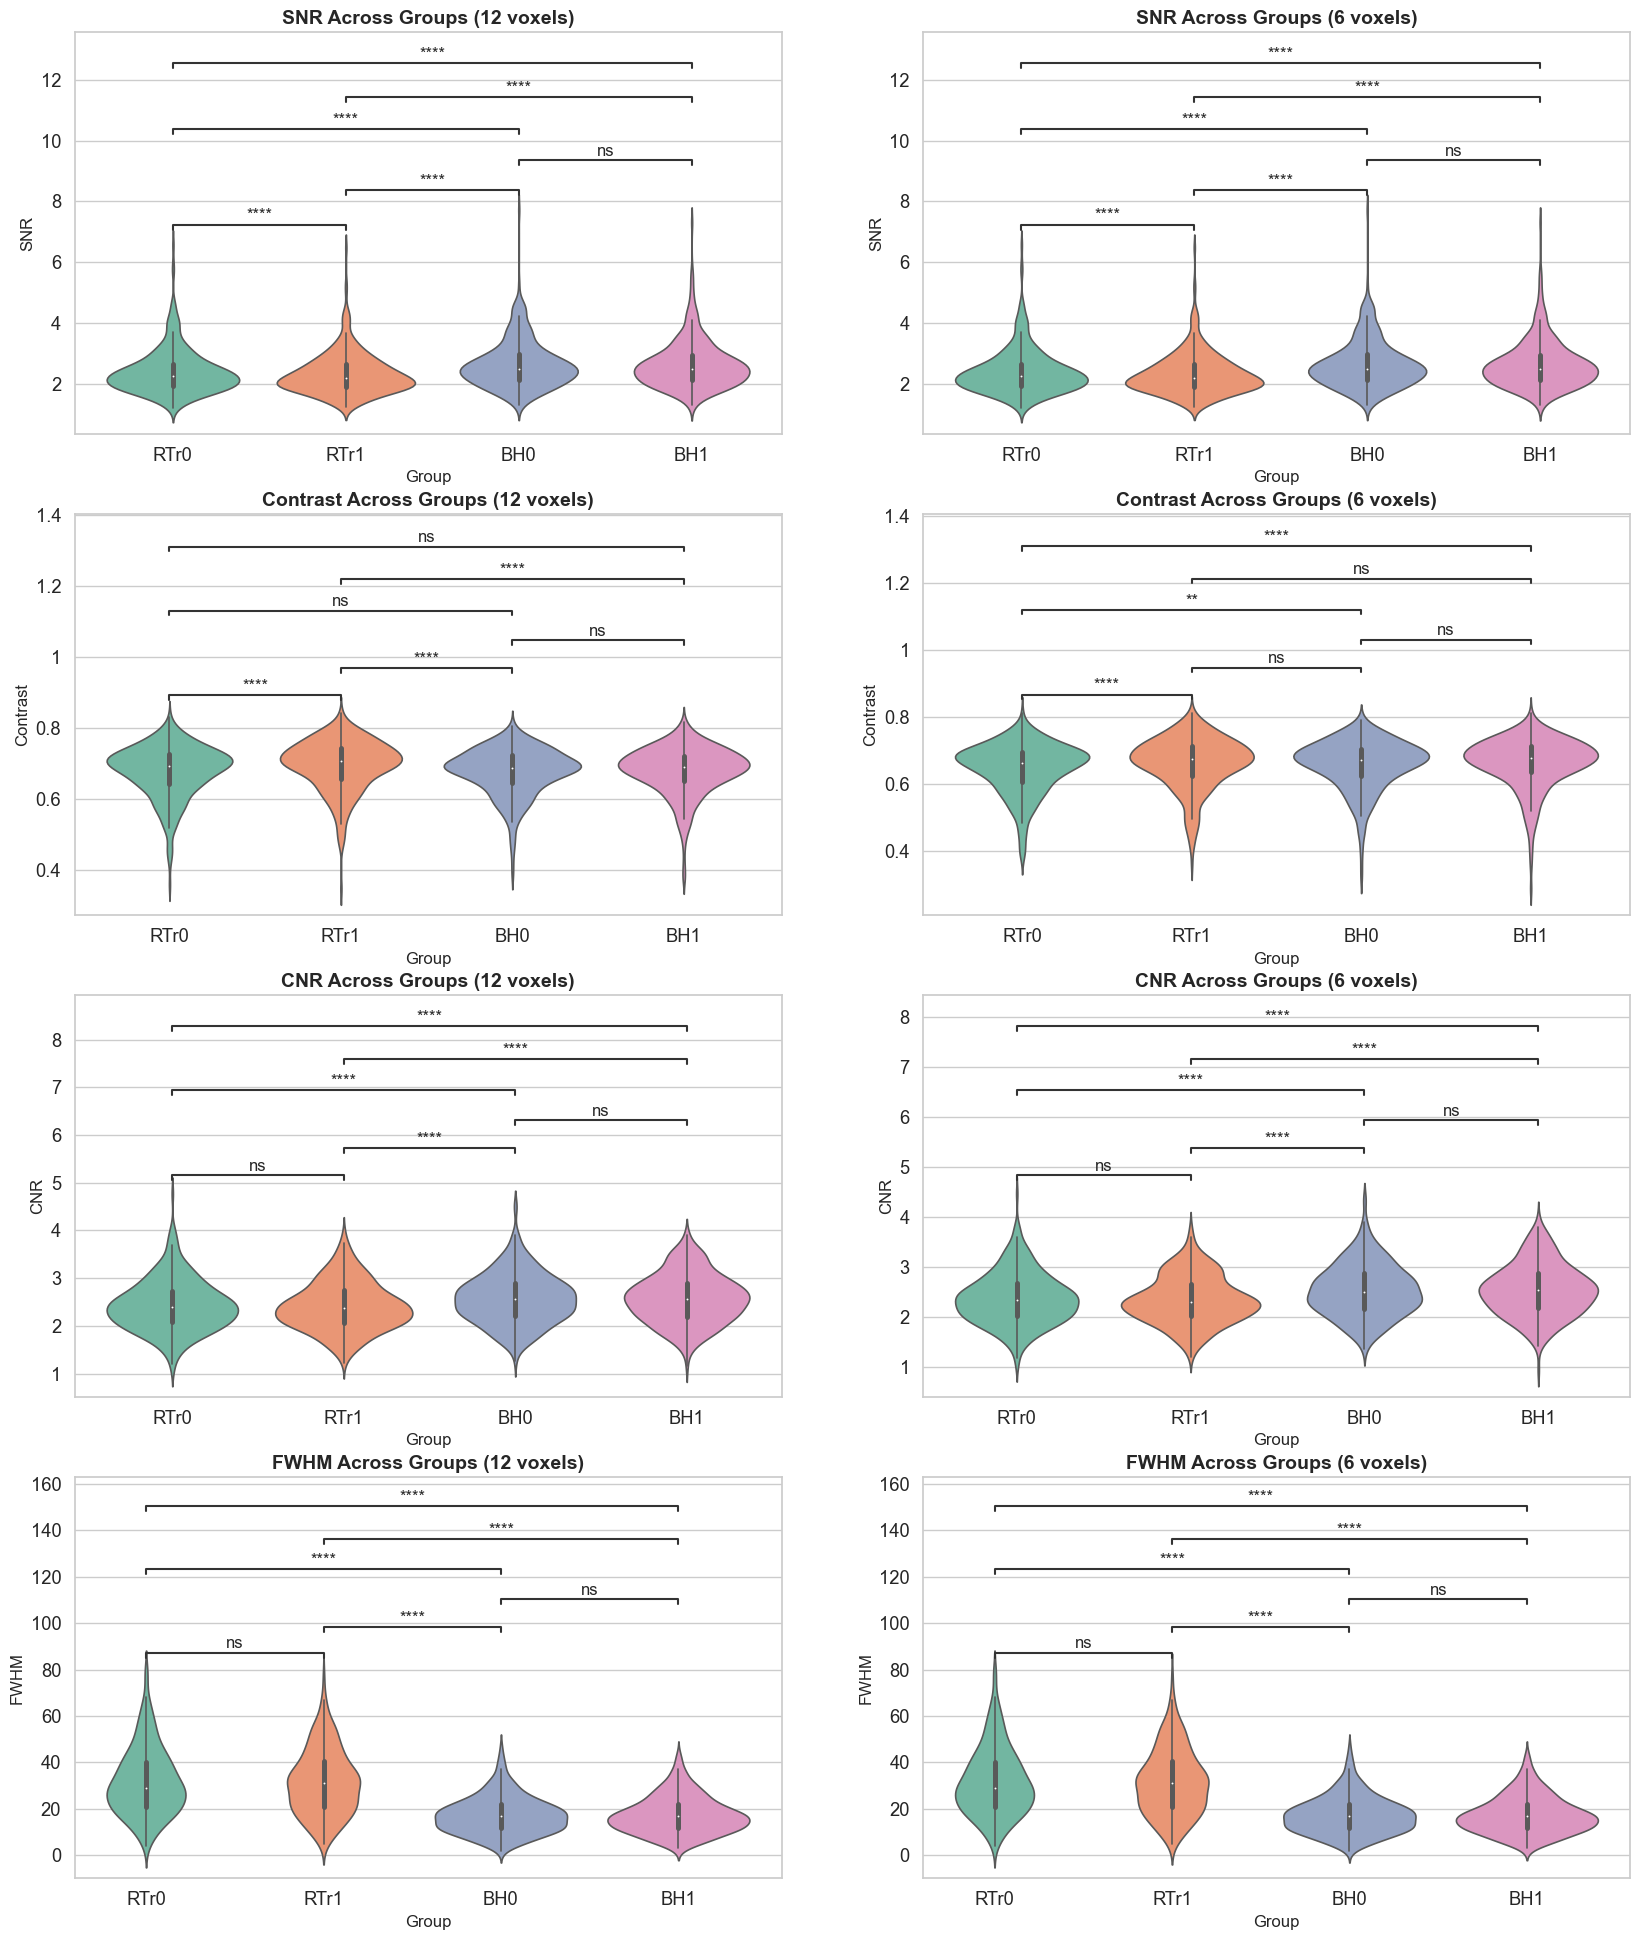

Paired Wilcoxon Test Results (12 voxels): {'SNR (RTr0 vs RTr1)': (16787.0, 5.2241537745380075e-06), 'SNR (RTr0 vs BH0)': (9343.0, 9.205555541119554e-21), 'SNR (RTr0 vs BH1)': (9445.0, 1.6911506758046794e-20), 'SNR (RTr1 vs BH0)': (7239.0, 1.3051321067870782e-26), 'SNR (RTr1 vs BH1)': (6085.0, 3.832682106999623e-30), 'SNR (BH0 vs BH1)': (23296.0, 0.6096127797391866), 'Contrast (RTr0 vs RTr1)': (11495.0, 2.3296963998836488e-15), 'Contrast (RTr0 vs BH0)': (22040.0, 0.19160414227298028), 'Contrast (RTr0 vs BH1)': (23546.0, 0.7245820778558637), 'Contrast (RTr1 vs BH0)': (13183.0, 4.726504741675752e-12), 'Contrast (RTr1 vs BH1)': (14014.0, 1.687093743820259e-10), 'Contrast (BH0 vs BH1)': (22947.0, 0.4644178574526103), 'CNR (RTr0 vs RTr1)': (21313.0, 0.09371975067877783), 'CNR (RTr0 vs BH0)': (12342.0, 9.619364091371208e-14), 'CNR (RTr0 vs BH1)': (12589.0, 3.107818783010374e-13), 'CNR (RTr1 vs BH0)': (11574.0, 2.1516432434705555e-15), 'CNR (RTr1 vs BH1)': (11170.0, 2.6546008433466733e-16), 'C

In [ ]:
"""
Part4:
analyze the statistical distribution of the local dataset, 
and compare difference between the four MRCP groups
"""
from scipy.stats import wilcoxon, ttest_rel
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statannot import add_stat_annotation
import numpy as np

def perform_paired_wilcoxon_test(df, params, groups):
    wilcoxon_results = {}
    for param in params:
        for group1, group2 in pairs:
            if len(df.loc[df['Group'] == group1, param]) == len(df.loc[df['Group'] == group2, param]):
                stat, p_value = wilcoxon(df.loc[df['Group'] == group1, param], df.loc[df['Group'] == group2, param])
                wilcoxon_results[f"{param} ({group1} vs {group2})"] = (stat, p_value)
            else:
                wilcoxon_results[f"{param} ({group1} vs {group2})"] = (None, None)
    return wilcoxon_results

def perform_paired_t_test(df, groups):
    ttest_results = {}
    for group1, group2 in pairs:
        group1_data = np.log(df.loc[df['Group'] == group1, 'CNR'])
        group2_data = np.log(df.loc[df['Group'] == group2, 'CNR'])
        if len(group1_data) == len(group2_data):
            stat, p_value = ttest_rel(group1_data, group2_data)
            ttest_results[f"{group1} vs {group2}"] = (stat, p_value)
        else:
            ttest_results[f"{group1} vs {group2}"] = (None, None)
    return ttest_results

def save_stat_results(file_path, wilcoxon_results, ttest_results):
    with pd.ExcelWriter(file_path) as writer:
        pd.DataFrame(wilcoxon_results, index=["Test Statistic", "p-value"]).T.to_excel(writer, sheet_name="Paired_Wilcoxon_Test")
        pd.DataFrame(ttest_results, index=["Test Statistic", "p-value"]).T.to_excel(writer, sheet_name="Paired_T_Test")

def create_combined_violin_plots(df, params, groups, file_path, pairs):
    sns.set(style="whitegrid", font_scale=1.2)
    plt.figure(figsize=(18, 21))  # Adjust the size for 4x2 subplots
    palette = sns.color_palette("Set2")

    # Separate data based on the 'radius' column
    df_12voxels = df[df['Radius'] == '[12, 12, 12]']
    df_6voxels = df[df['Radius'] == '[6, 6, 6]']

    for i, param in enumerate(params, 1):
        plt.subplot(4, 2, i*2-1)  # Subplot for 12-voxel data
        ax = sns.violinplot(x="Group", y=param, data=df_12voxels, palette=palette, inner="box", linewidth=1.2)
        plt.title(f"{param} Across Groups (12 voxels)", fontsize=14, weight='bold')
        plt.xlabel("Group", fontsize=12)
        plt.ylabel(param, fontsize=12)

        # Add paired test annotations
        if param == 'CNR':
            add_stat_annotation(ax, data=df_12voxels, x="Group", y=param, box_pairs=pairs, test='t-test_paired', 
                                text_format='star', loc='inside', verbose=2, fontsize='small')
        else:
            add_stat_annotation(ax, data=df_12voxels, x="Group", y=param, box_pairs=pairs, test='Wilcoxon', 
                                text_format='star', loc='inside', verbose=2, fontsize='small')

        ax.get_yaxis().get_major_formatter().set_scientific(False)
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}' if x.is_integer() else f'{x:.1f}'))

        plt.subplot(4, 2, i*2)  # Subplot for 6-voxel data
        ax = sns.violinplot(x="Group", y=param, data=df_6voxels, palette=palette, inner="box", linewidth=1.2)
        plt.title(f"{param} Across Groups (6 voxels)", fontsize=14, weight='bold')
        plt.xlabel("Group", fontsize=12)
        plt.ylabel(param, fontsize=12)

        # Add paired test annotations
        if param == 'CNR':
            add_stat_annotation(ax, data=df_6voxels, x="Group", y=param, box_pairs=pairs, test='t-test_paired', 
                                text_format='star', loc='inside', verbose=2, fontsize='small')
        else:
            add_stat_annotation(ax, data=df_6voxels, x="Group", y=param, box_pairs=pairs, test='Wilcoxon', 
                                text_format='star', loc='inside', verbose=2, fontsize='small')

        ax.get_yaxis().get_major_formatter().set_scientific(False)
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}' if x.is_integer() else f'{x:.1f}'))

    plt.tight_layout(pad=4.5)
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.savefig(file_path)
    plt.show()

def main_with_radius(file_path, output_dir, params, groups, pairs):
    df = pd.read_excel(file_path)

    # Step 1: Perform paired Wilcoxon test for non-CNR parameters
    df_12voxels = df[df['Radius'] == '[12, 12, 12]']
    df_6voxels = df[df['Radius'] == '[6, 6, 6]']

    wilcoxon_results12 = perform_paired_wilcoxon_test(df_12voxels, params, groups)
    wilcoxon_results6 = perform_paired_wilcoxon_test(df_6voxels, params, groups)

    # Step 2: Perform paired t-test for log-transformed CNR
    ttest_results12 = perform_paired_t_test(df_12voxels, groups)
    ttest_results6 = perform_paired_t_test(df_6voxels, groups)

    # Step 3: Save statistical results for both 12-voxel and 6-voxel data
    save_stat_results(f'{output_dir}/Paired_Wilcoxon_Results_12voxels.xlsx', wilcoxon_results12, ttest_results12)
    save_stat_results(f'{output_dir}/Paired_Wilcoxon_Results_6voxels.xlsx', wilcoxon_results6, ttest_results6)

    # Step 4: Create and save combined violin plots for both 12-voxel and 6-voxel data
    create_combined_violin_plots(df, params, groups, f'{output_dir}/Supplemental Figure_4.pdf', pairs)

    # Step 5: Print results
    print(f"Paired Wilcoxon Test Results (12 voxels):", wilcoxon_results12)
    print(f"Paired Wilcoxon Test Results (6 voxels):", wilcoxon_results6)
    print("\nPaired T-test Results (12 voxels):", ttest_results12)
    print("\nPaired T-test Results (6 voxels):", ttest_results6)

# Define common parameters and groups
params = ["SNR", "Contrast", "CNR", "FWHM"]
groups = ["RTr0", "RTr1", "BH0", "BH1"]
pairs = [("RTr0", "RTr1"), ("RTr0", "BH0"), ("RTr0", "BH1"), ("RTr1", "BH0"), ("RTr1", "BH1"), ("BH0", "BH1")]

# Process data with 'radius' column for both 12-voxel and 6-voxel groups
main_with_radius('/Users/ziling/Desktop/MRCP/results/MRCP_LocData.xlsx', 
                 '/Users/ziling/Desktop/MRCP/results', 
                 params, 
                 groups, 
                 pairs)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

LocData v.s. CPTAC-PDA: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.300e-01 U_stat=5.450e+03
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

LocData v.s. CPTAC-PDA: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.300e-01 U_stat=5.450e+03
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

LocData v.s. CPTAC-PDA: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.226e-02 U_stat=3.065e+03
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03

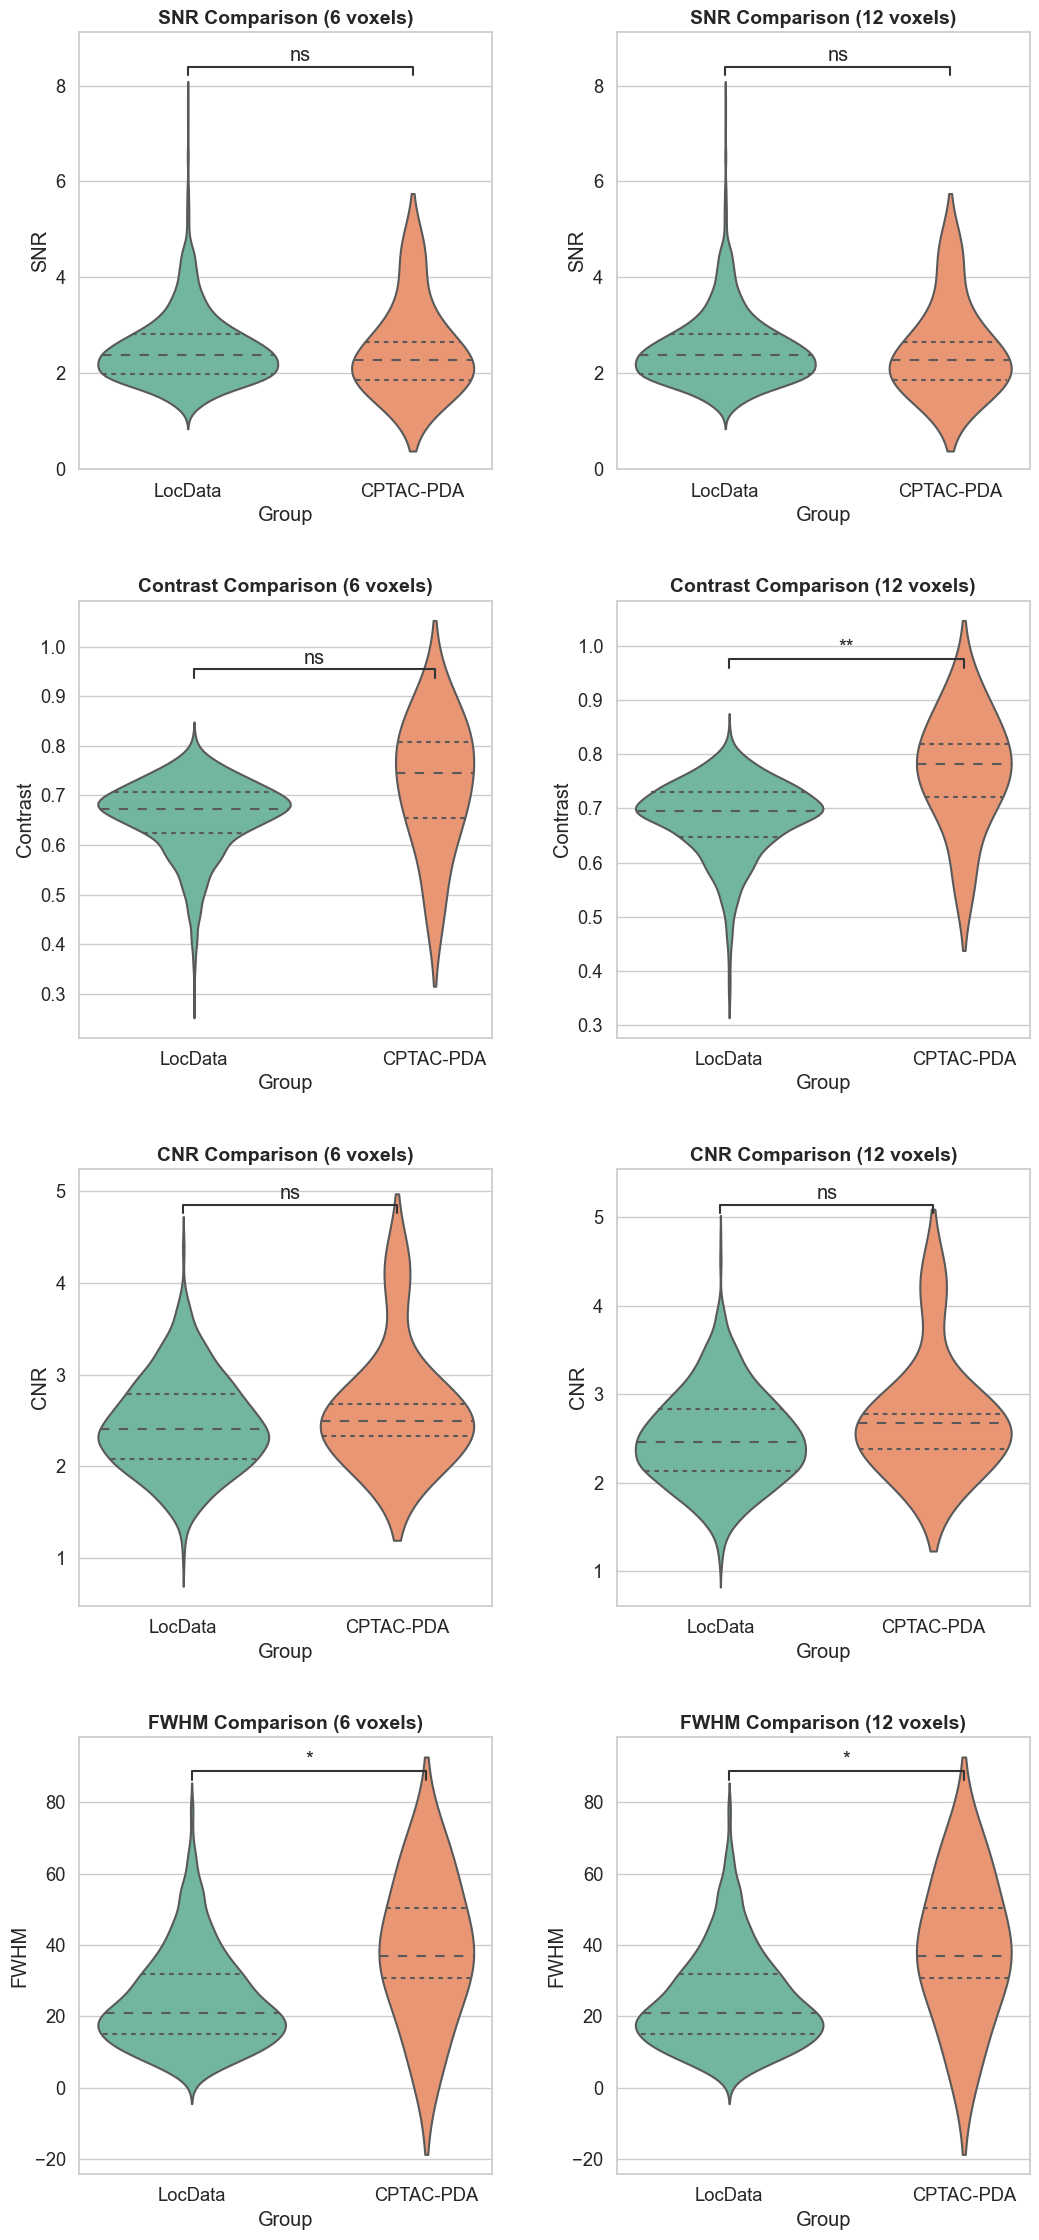

Analysis complete. Combined results saved to /Users/ziling/Desktop/MRCP/results/Supplemental Figure_5.pdf


In [3]:
"""
This Python script analyzes MRI data parameters (SNR, Contrast, CNR, FWHM) 
across two groups—`LocData` and `CPTAC-PDA`—for two different voxel sizes 
(`[6,6,6]` and `[12,12,12]`). It uses the Mann-Whitney U test to perform 
pairwise comparisons between the groups and visualizes the data through violin plots, 
which include statistical significance annotations. The script outputs the visual 
comparisons in PDF format, providing an easy-to-interpret graphical representation 
of the differences between the groups for each parameter and voxel size.
"""
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from statannot import add_stat_annotation

# Load the data for the two groups (replace with your actual file paths)
group1_path = '/Users/ziling/Desktop/MRCP/results/MRCP_LocData.xlsx'  # Replace with actual file path
group2_path = '/Users/ziling/Desktop/MRCP/results/MRCP_CPTAC.xlsx'    # Replace with actual file path

# Read the data
group1 = pd.read_excel(group1_path)
group2 = pd.read_excel(group2_path)

# Add a column to identify the group
group1['Group'] = 'LocData'
group2['Group'] = 'CPTAC-PDA'

# Concatenate the datasets
all_data = pd.concat([group1, group2], ignore_index=True)

# Create a new column for voxel size based on the 'Radi' column
all_data['Voxel Size'] = all_data['Radius'].apply(lambda x: '6 voxels' if '[6, 6, 6]' in x else '12 voxels')

# Set up the figure with 4 rows and 2 columns to display each parameter's comparison for both voxel sizes in a row
plt.figure(figsize=(12, 24))
palette = sns.color_palette("Set2")
pairs = [('LocData', 'CPTAC-PDA')]

# Define the parameters and their respective row positions for consistent plotting
parameters = ['SNR', 'Contrast', 'CNR', 'FWHM']
titles = ['SNR', 'Contrast', 'CNR', 'FWHM']

for idx, param in enumerate(parameters):
    for voxel_size_idx, voxel_size in enumerate(['6 voxels', '12 voxels']):
        # Filter the data for the current voxel size
        voxel_data = all_data[all_data['Voxel Size'] == voxel_size]

        # Violin plot for each parameter at the given voxel size
        plt.subplot(4, 2, idx * 2 + voxel_size_idx + 1)
        ax = sns.violinplot(x='Group', y=param, data=voxel_data, palette=palette, inner='quartile')
        add_stat_annotation(ax, data=voxel_data, x='Group', y=param,
                            box_pairs=pairs,
                            test='Mann-Whitney', text_format='star', loc='inside', verbose=2)
        plt.title(f'{titles[idx]} Comparison ({voxel_size})', fontsize=14, weight='bold')

# Adjust layout and spacing
plt.tight_layout(pad=4.5)
plt.subplots_adjust(hspace=0.3, wspace=0.3)

# Save the combined plot
output_pdf = "/Users/ziling/Desktop/MRCP/results/Supplemental Figure_5.pdf"
plt.savefig(output_pdf)

# Show the plot
plt.show()

print(f"Analysis complete. Combined results saved to {output_pdf}")